# Lab 2: Базові алгоритми навчання без учителя та обробка текстових даних (Scikit-learn lib)

**Файли для цієї версії:**
- `netflix_titles.csv` — дані для частини 1 (класифікація + PCA + t‑SNE),
- `image.png` — зображення для квантування кольорів (k‑means),
- `email_spam.csv` — тексти для класифікації (TF‑IDF) та wordcloud.


## 0) Підготовка середовища
За потреби встановіть залежності (якщо не встановлено у системі).

In [1]:
import sys, subprocess
def pip_install(pkg):
    try:
        __import__(pkg.split('==')[0].split('[')[0].replace('-', '_'))
    except Exception:
        try:
            print(f"Installing {pkg} ...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])
        except Exception as e:
            print(f"⚠️ Не вдалося встановити {pkg}: {e}")

for p in ['numpy','pandas','matplotlib','scikit-learn','pillow','wordcloud','tqdm']:
    pip_install(p)
print('✅ Перевірка встановлення завершена.')

Installing scikit-learn ...
Installing pillow ...
✅ Перевірка встановлення завершена.


## 1) Зниження розмірності та класифікація (дані: `netflix_titles.csv`)
**Мета:**
- Побудувати ознаки з Netflix датасету (рік випуску, числова тривалість, one‑hot для рейтингів, топ‑жанрів і топ‑країн),
- Класифікувати `type` (Movie vs TV Show) на вихідних ознаках та після PCA (95% дисперсії),
- Порівняти точність і час навчання, зробити висновок,
- Знизити простір до 2D за допомогою t‑SNE та візуалізувати.

In [2]:
from pathlib import Path
import time, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

CSV_PATH = 'netflix_titles.csv'
TARGET_COL = 'type'
ALG = 'knn'  # 'knn' або 'logreg'
K_FOR_KNN = 7
RANDOM_STATE = 42
TOP_N_GENRES = 15
TOP_N_COUNTRIES = 15

def parse_duration_to_num(s: str):
    if not isinstance(s, str):
        return np.nan
    m = re.search(r'(\d+)', s)
    if not m:
        return np.nan
    return float(m.group(1))

def top_tokens_from_col(series, sep=',', top_n=15):
    tokens = []
    for x in series.dropna():
        tokens.extend([t.strip() for t in str(x).split(sep) if t.strip()])
    most_common = [t for t,_ in Counter(tokens).most_common(top_n)]
    return most_common

def binarize_multilabel(series, vocab, sep=','):
    data = np.zeros((len(series), len(vocab)), dtype=int)
    for i, x in enumerate(series.fillna('')):
        items = [t.strip() for t in str(x).split(sep) if t.strip()]
        for j, token in enumerate(vocab):
            if token in items:
                data[i, j] = 1
    cols = [f"ml_{str(col).replace(' ', '_')}" for col in vocab]
    return pd.DataFrame(data, columns=cols)

def load_netflix_data(csv_path: str, target_col: str = 'type', top_n_genres=15, top_n_countries=15):
    df = pd.read_csv(csv_path)
    y = df[target_col].copy()
    X_num = pd.DataFrame({
        'release_year': df['release_year'],
        'duration_num': df['duration'].apply(parse_duration_to_num),
    })
    rating = df['rating'].fillna('Unknown').astype(str)
    X_rating = pd.get_dummies(rating, prefix='rating', dtype=int)
    top_genres = top_tokens_from_col(df['listed_in'], sep=',', top_n=top_n_genres)
    top_countries = top_tokens_from_col(df['country'], sep=',', top_n=top_n_countries)
    X_genres = binarize_multilabel(df['listed_in'], top_genres, sep=',')
    X_countries = binarize_multilabel(df['country'], top_countries, sep=',')
    X = pd.concat([X_num, X_rating, X_genres, X_countries], axis=1)
    valid = (~y.isna()) & (~X['release_year'].isna()) & (~X['duration_num'].isna())
    X = X.loc[valid].reset_index(drop=True)
    y = y.loc[valid].reset_index(drop=True)
    if y.dtype == 'O':
        y = y.astype('category').cat.codes
    return X.values, y.values, X.columns

def build_clf(algo='knn'):
    if algo == 'logreg':
        from sklearn.linear_model import LogisticRegression
        return LogisticRegression(max_iter=1000)
    return KNeighborsClassifier(n_neighbors=K_FOR_KNN)

X, y, feature_names = load_netflix_data(CSV_PATH, TARGET_COL, TOP_N_GENRES, TOP_N_COUNTRIES)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler(with_mean=True, with_std=True)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

clf_raw = build_clf(ALG)
t0 = time.time()
clf_raw.fit(X_train_sc, y_train)
train_time_raw = time.time() - t0
y_pred_raw = clf_raw.predict(X_test_sc)
acc_raw = accuracy_score(y_test, y_pred_raw)

print(f"Samples: {len(X)} | Features: {X.shape[1]}")
print(f"Accuracy (raw): {acc_raw:.4f}\nЧас навчання (raw): {train_time_raw:.4f} c")
print(classification_report(y_test, y_pred_raw))

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca  = pca.transform(X_test_sc)
print(f"PCA n_components: {pca.n_components_}")

clf_pca = build_clf(ALG)
t0 = time.time()
clf_pca.fit(X_train_pca, y_train)
train_time_pca = time.time() - t0
y_pred_pca = clf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"Accuracy (PCA): {acc_pca:.4f}\nЧас навчання (PCA): {train_time_pca:.4f} c")
print(classification_report(y_test, y_pred_pca))

delta_acc = acc_pca - acc_raw
speedup = train_time_raw / train_time_pca if train_time_pca > 0 else float('inf')
print('\n=== Чернетка висновку ===')
print(f"Після PCA компонент: {pca.n_components_}. Прискорення навчання ≈ {speedup:.2f} раз(и). ")
print(f"Зміна точності: {delta_acc:+.4f} (raw={acc_raw:.4f} → PCA={acc_pca:.4f}).")

Samples: 8804 | Features: 50
Accuracy (raw): 0.9920
Час навчання (raw): 0.0015 c
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1226
           1       1.00      0.98      0.99       535

    accuracy                           0.99      1761
   macro avg       0.99      0.99      0.99      1761
weighted avg       0.99      0.99      0.99      1761

PCA n_components: 39
Accuracy (PCA): 0.9875
Час навчання (PCA): 0.0017 c
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1226
           1       0.99      0.97      0.98       535

    accuracy                           0.99      1761
   macro avg       0.99      0.98      0.99      1761
weighted avg       0.99      0.99      0.99      1761


=== Чернетка висновку ===
Після PCA компонент: 39. Прискорення навчання ≈ 0.87 раз(и). 
Зміна точності: -0.0045 (raw=0.9920 → PCA=0.9875).


### Візуалізація t‑SNE (2D)
Локально вирізняє кластери, але не гарантує глобальні відстані. Також чутлива до гіперпараметрів.

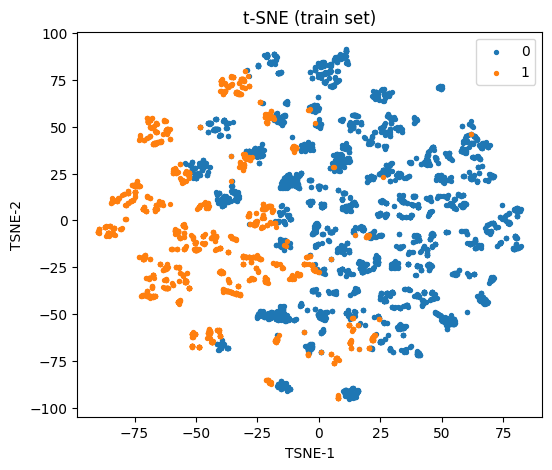

In [3]:
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42)
X_2d = tsne.fit_transform(X_train_sc)
plt.figure(figsize=(6,5))
for lab in np.unique(y_train):
    idx = (y_train == lab)
    plt.scatter(X_2d[idx,0], X_2d[idx,1], s=8, label=str(lab))
plt.title('t-SNE (train set)')
plt.legend()
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()

In [ ]:
Висновки по PCA

Початково було 50 ознак, після PCA залишилось 39 компонент, що зберігають 95% дисперсії.

Точність класифікації до PCA: 0.9920, після PCA: 0.9875.
→ Вона трохи знизилася (на ~0.45%).

Час навчання майже не змінився (0.0015 c → 0.0017 c), тобто прискорення не отримали — навіть невелике уповільнення, оскільки початково ознак було небагато (50).

Висновок: PCA не дало значного виграшу в швидкості, але й не зіпсувало сильно якість. Для такого датасету з малою кількістю ознак PCA не критично потрібне.

Висновки по t-SNE (2D)

На графіку видно, що дані у 2D розклалися у відносно компактні кластери, але повного розділення між класами немає — групи перекриваються.

t-SNE добре відображає локальні відносини (сусіди залишаються близькими), але не зберігає глобальні відстані.

Це підтверджує, що у початкових даних класи мають певну структуру, проте їхні ознаки частково накладаються.

Висновок: t-SNE є зручним методом для візуалізації у 2D і підтверджує, що класи відокремлюються непогано, але мають зони перекриття.

## 2) Кластерний аналіз зображення: квантування кольорів (k‑means)
Файл очікується: **image.png**.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.76s/it]


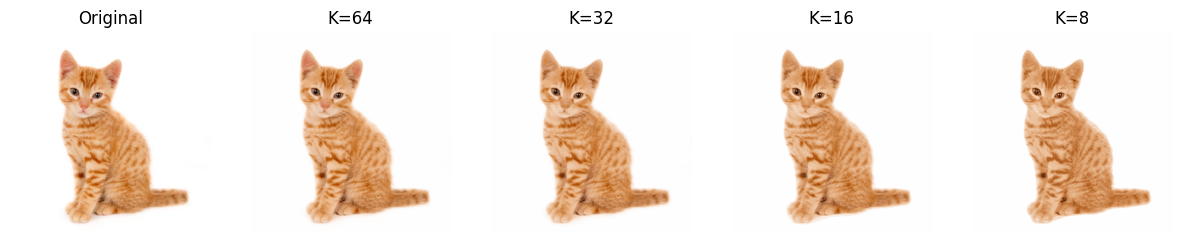

K=64: MSE=5.22
K=32: MSE=8.63
K=16: MSE=15.27
K=8: MSE=31.49


In [4]:
from PIL import Image
from sklearn.cluster import KMeans
from tqdm import tqdm

IMG_PATH = 'image.png'
OUTPUT_DIR = 'quantized_outputs'
Path(OUTPUT_DIR).mkdir(exist_ok=True)

img = Image.open(IMG_PATH).convert('RGB')
img_np = np.array(img)
h,w,_ = img_np.shape
pixels = img_np.reshape(-1,3).astype(float)

levels = [64,32,16,8]
results = {}
for k in tqdm(levels):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(pixels)
    centers = km.cluster_centers_
    quantized = centers[labels].reshape(h,w,3).clip(0,255).astype('uint8')
    out_path = Path(OUTPUT_DIR)/f'quantized_{k}.png'
    Image.fromarray(quantized).save(out_path)
    results[k] = out_path

fig, axes = plt.subplots(1, len(levels)+1, figsize=(3*(len(levels)+1), 3))
axes[0].imshow(img_np)
axes[0].set_title('Original')
axes[0].axis('off')
for i,k in enumerate(levels, start=1):
    q = np.array(Image.open(results[k]))
    axes[i].imshow(q)
    axes[i].set_title(f'K={k}')
    axes[i].axis('off')
plt.show()

def mse(a,b):
    return np.mean((a.astype(float)-b.astype(float))**2)
for k in levels:
    q = np.array(Image.open(results[k]))
    print(f"K={k}: MSE={mse(img_np, q):.2f}")

## 3) Обробка та класифікація текстових даних (CSV: `email_spam.csv`)
Очікується CSV із колонками для **тексту** та **мітки**. Колонки визначаються автоматично серед поширених назв.

Використовую стовпці -> TEXT='text', LABEL='type'


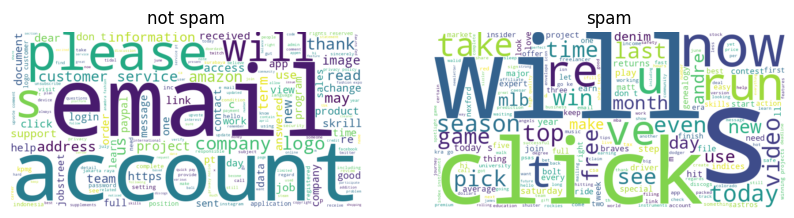

Час навчання (текст): 0.02 c
              precision    recall  f1-score   support

    not spam       0.69      0.92      0.79        12
        spam       0.00      0.00      0.00         5

    accuracy                           0.65        17
   macro avg       0.34      0.46      0.39        17
weighted avg       0.49      0.65      0.55        17



In [6]:
# === 3) Обробка та класифікація текстових даних (email_spam.csv) ===
# Надійне завантаження CSV з автодетектом колонок (включно з 'type')

import re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

CSV_TEXT_PATH = 'email_spam.csv'

TEXT_CANDIDATES  = ['text','message','email','content','body','msg','mail']
LABEL_CANDIDATES = ['label','class','target','is_spam','spam','category','y','type']

def guess_text_col(df):
    lower = [c.lower() for c in df.columns]
    for cand in TEXT_CANDIDATES:
        if cand in lower:
            return df.columns[lower.index(cand)]
    # якщо нема точного збігу — беремо колонку з найбільшою довжиною рядка
    text_col, best_len = None, -1
    for c in df.columns:
        s = df[c].astype(str).fillna('')
        avg = s.str.len().mean()
        if avg > best_len:
            best_len, text_col = avg, c
    return text_col

def guess_label_col(df, text_col):
    lower = [c.lower() for c in df.columns]
    for cand in LABEL_CANDIDATES:
        if cand in lower and df.columns[lower.index(cand)] != text_col:
            return df.columns[lower.index(cand)]
    # fallback: вибрати колонку з невеликою кількістю унікальних значень
    candidates = []
    for c in df.columns:
        if c == text_col: 
            continue
        uniq = df[c].nunique(dropna=True)
        if uniq <= 10:
            candidates.append((uniq, c))
    if candidates:
        candidates.sort()
        return candidates[0][1]
    # якщо нічого — остання колонка, що не text_col
    for c in df.columns[::-1]:
        if c != text_col:
            return c
    return None

df_text = pd.read_csv(CSV_TEXT_PATH)

TEXT_COLUMN  = guess_text_col(df_text)
LABEL_COLUMN = guess_label_col(df_text, TEXT_COLUMN)
print(f"Використовую стовпці -> TEXT='{TEXT_COLUMN}', LABEL='{LABEL_COLUMN}'")

texts_raw = df_text[TEXT_COLUMN].astype(str).tolist()
labels_raw = df_text[LABEL_COLUMN].astype(str)

labels_cat = labels_raw.astype('category')
label_names = list(labels_cat.cat.categories)
y_text = labels_cat.cat.codes.values

def basic_clean(s: str):
    s = str(s).lower()
    s = re.sub(r"[0-9]+", " ", s)
    s = re.sub(r"[^\w\s]", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+", " ", s).strip()
    return s

texts_clean = [basic_clean(t) for t in texts_raw]

# WordCloud по класах
def show_wordcloud_per_class(texts, labels, label_names):
    agg = defaultdict(list)
    for t,lab in zip(texts, labels):
        agg[lab].append(t)
    n = len(label_names)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
    if n == 1: axes = [axes]
    stopwords = set(STOPWORDS)
    for i,name in enumerate(label_names):
        txt = ' '.join(agg[i])
        wc = WordCloud(width=800, height=400, stopwords=stopwords, background_color='white').generate(txt)
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(name)
    plt.show()

show_wordcloud_per_class(texts_clean, y_text, label_names)

# Класифікація (TF-IDF + LinearSVC або Naive Bayes)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    texts_clean, y_text, test_size=0.2, random_state=42, stratify=y_text
)

TEXT_MODEL = 'linsvc'  # 'linsvc' або 'nb'

if TEXT_MODEL == 'nb':
    model = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=30000, ngram_range=(1,2)) ),
        ('clf', MultinomialNB()),
    ])
else:
    model = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=30000, ngram_range=(1,2)) ),
        ('clf', SGDClassifier(loss='hinge', max_iter=3000, random_state=42)),
    ])

t0 = time.time()
model.fit(X_train_t, y_train_t)
train_time = time.time() - t0
y_pred_t = model.predict(X_test_t)

print(f"Час навчання (текст): {train_time:.2f} c")
print(classification_report(y_test_t, y_pred_t, target_names=label_names))
